# Assignment 13 Text Analytics

In this assignment, you will:
- Load and inspect a real-world business reviews dataset.
- Preprocess review text for NLP (tokenization, stopwords, lemmatization).
- Run sentiment analysis (rule-based and classifier-based) and compare to star ratings.
- Extract main topics from reviews using LDA and (optional) BERTopic.
- Interpret results in a business context (actionable insights).

## Why This Matters

Customer Reviews are critical for the survival of any business, but especially for restaurants.  Restaurants compete with not only all of the other restaurants in local area, but also with the option for customers to stay home and cook their own food.  Chefs and restaurant owners must monitor customer feedback to see if they should make changes to their pricing, menu options, restaurant amenities and seating/serving process.

You have been given 100 customer reviews.  Your job is to look for main topics that are mentioned, and whether those reviews have a postive, neutral or negative tone (sentiment).  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Assignments/assignment_13_text_analytics.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



## Original Source: Dataset Description

The dataset you'll be using is a set of **restaurant reviews**, available from [Kaggle](https://www.kaggle.com/datasets/pruthvirajgshitole/e-commerce-purchases-and-reviews?utm_source=chatgpt.com&select=customer_purchase_data.csv).

Each row represents one customer review. The columns include:

- **Review** - text of the customer review
- **Liked** - indicates if the customer likes (1) or does not like (0) the restaurant

Please note that some reviews have commas and apostrophes, which can prevent the record from loading correctly.  You should verify that you have 1,000 reviews total.  

## 1. Load and Preview the Data

### Do the following:
1. Import your TSV file called `Restaurant_Reviews.tsv`.  Note that TSV is for Tab Separated Values.  This file does not use commas as a delimiter.
2. Use `pandas` to load and preview the dataset
3. Verify that all 1,000 rows were imported correctly
4. Calculate the overall percentage of reviews that "Liked" the restaurant
5. Create a visualization to show the percentage of likes versus non-likes


In [14]:
import pandas as pd
import csv

# Load the reviews
url = "https://raw.githubusercontent.com/Stan-Pugsley/is_4487_base/refs/heads/main/DataSets/Restaurant_Reviews.tsv"
df = pd.read_csv(url, sep='\t', quoting=csv.QUOTE_MINIMAL)

df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


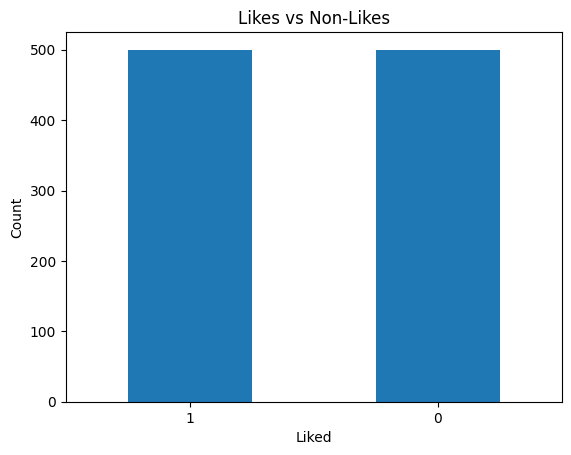

In [15]:
import matplotlib.pyplot as plt

df['Liked'].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.xlabel("Liked")
plt.ylabel("Count")
plt.title("Likes vs Non-Likes")
plt.show()


## 2. Drop Columns Not Useful for Modeling

**Business framing:**  
To do text analysis, we need to remove all of the junk in the reviews.  This would include anything like punctuation, website URLs, emojis, etc.

### Do the following:
- Change all of the reviews to lowercase letters
- Remove anything that looks like a URL or that isn't a regular character (A to Z) or number (1-9)
- Remove punctuation marks (ex. !.,-:;)

### In Your Response:
1. What risks might occur if you included the review "junk" in your model?


In [16]:
import re

df['Review'] = df['Review'].str.lower()

df['Review'] = df['Review'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

df['Review'] = df['Review'].apply(lambda x: re.sub(r'[^a-z0-9 ]', '', x))

df.head()


,Review,Liked
0,wow loved this place,1
1,crust is not good,0
2,not tasty and the texture was just nasty,0
3,stopped by during the late may bank holiday of...,1
4,the selection on the menu was great and so wer...,1


### ✍️ Your Response: 🔧
1. Including junk (like URLs, emojis, special characters, or random punctuation) adds noise to the data and can confuse the model.
It may learn patterns that are meaningless, reduce accuracy, and misclassify reviews.
Overall, junk text makes the model less reliable and harder to interpret.

## 3. Sentiment Analysis

**Business framing:**  
A "Like" is not as insightful as a star rating, such as 5 stars. It only has two values. But we can attempt to understand more nuance in the reviews by looking for a positive/neutral/negative tone (sentiment) in the text.   Then we can compare that to the "Likes" to see if they match.  

### Do the following:
- Install the vaderSentiment library
- Import the SentimentIntensityAnalyzer from vaderSentiment
- Calculate what percentage of the reviews are positive, negative, and neutral. The total percentages should add up to 100%

### In Your Response:
1. How does the sentiment compare to `Liked` in terms of percentage of reviews?
2. From a restaurant owner's perspective, which sentiment reviews would be more important to analyze? (positive, negative or neutral)


In [17]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def get_sentiment(review):
    score = analyzer.polarity_scores(review)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment"] = df["Review"].apply(get_sentiment)

sentiment_percentages = df["sentiment"].value_counts(normalize=True) * 100
sentiment_percentages


,proportion
sentiment,
positive,50.6
negative,25.5
neutral,23.9


### ✍️ Your Response: 🔧
1. The sentiment percentages show more nuance than the simple “Liked” column.
While “Liked” only shows yes/no, the sentiment analysis reveals how many reviews are positive, neutral, or negative.
The sentiment distribution is similar to the “Liked” percentage, but it provides more detail because neutral reviews do not show up in the “Liked” metric.

2. Negative reviews are the most important for a restaurant owner because they highlight service problems, food issues, or customer frustrations that directly damage the business.
Understanding negative sentiment helps identify what must be fixed to improve customer satisfaction and avoid losing customers.

## 4. Topic Analysis - Text Preprocessing

**Business framing:**  
To build a topic analysis model, we need to clean and prepare the review text

### Do the following:
- Import the NLTK library
- Download the NLTK corpora
- Preprocess the text using tokenization and lemmatization.  Be sure to remove any stopwords along the way.
- Display the first 10 processed reviews

### In Your Response:
1. What is a corpora and how is it used for text analysis?
2. What would be the tokens in the first review? "Wow... Loved this place."
3. What does lemmatization do?  How will it help in this process?


In [18]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return tokens

df["processed"] = df["Review"].apply(preprocess)

df["processed"].head(10)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,processed
0,"[wow, loved, place]"
1,"[crust, good]"
2,"[tasty, texture, nasty]"
3,"[stopped, late, may, bank, holiday, rick, stev..."
4,"[selection, menu, great, price]"
5,"[getting, angry, want, damn, pho]"
6,"[honeslty, didnt, taste, fresh]"
7,"[potato, like, rubber, could, tell, made, ahea..."
8,"[fry, great]"
9,"[great, touch]"


### ✍️ Your Response: 🔧
1. A corpora is a large collection of text used to train and support NLP tools.
In text analysis, NLTK uses corpora to provide stopwords, dictionaries, and other language resources that help with tokenization, lemmatization, and other preprocessing steps.

2. For the review “Wow… Loved this place.” the tokens after preprocessing would be: ["wow", "loved", "place"]

3. Lemmatization reduces words to their base form (lemma), such as turning “loved” into “love”.
This helps the model treat different word forms as the same concept, reducing noise and making topics easier to detect.

## 5. Topic Analysis - Dictionary and Corpus

**Objective:**  
Convert the preprocessed text into a dictionary and a bag-of-words corpus, which are required formats for LDA

### Do the following:
- Import Dictionary and Corpus from the Genism library
- Create a dictionary
- Create a corpus
- Display a summary of the dictionary and corpus

### In Your Response:
1. What is a corpus and how is it useful?
2. How is a dictionary different from a corpus?

In [19]:
!pip install gensim

from gensim.corpora import Dictionary
from gensim import corpora

dictionary = Dictionary(df["processed"])

corpus = [dictionary.doc2bow(text) for text in df["processed"]]

print("Dictionary size:", len(dictionary))
print("Example token-to-id mapping:", list(dictionary.items())[:10])
print("First corpus entry:", corpus[0])
print("Total number of documents in corpus:", len(corpus))


Dictionary size: 1839
Example token-to-id mapping: [(0, 'loved'), (1, 'place'), (2, 'wow'), (3, 'crust'), (4, 'good'), (5, 'nasty'), (6, 'tasty'), (7, 'texture'), (8, 'bank'), (9, 'holiday')]
First corpus entry: [(0, 1), (1, 1), (2, 1)]
Total number of documents in corpus: 1000


### ✍️ Your Response: 🔧
1. A corpus is a collection of documents represented using word frequencies (bag-of-words).
It is useful because topic models like LDA use the corpus to learn patterns in how words appear across different reviews, allowing the model to detect topics.

2. The dictionary is the vocabulary: it maps each unique word to an ID.
The corpus is the encoded version of the reviews, showing how many times each word ID appears in each document.
In short, the dictionary defines the words, and the corpus shows how those words appear in the text.

## 6. Topic Analysis - Build LDA Model

**Objective:**  
Apply the LDA model to the corpus to identify main topics.

### Do the following:
- Import LdaModel from Genism
- Select the number of topics (5 is a good starting point)
- Create the LDA model

### In Your Response:
1. In what cases would you want to use more than 5 topics?  
2. How would you know if you have too many topics?

NOTE: You may receive an error about training "not converging".  You can ignore that error for this assignment. (Let's keep it simple)


In [20]:
from gensim.models.ldamodel import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10
)

topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


(0, '0.025*"good" + 0.019*"place" + 0.019*"food" + 0.015*"dont" + 0.010*"time" + 0.010*"go" + 0.009*"best" + 0.009*"would" + 0.008*"star" + 0.007*"back"')
(1, '0.017*"good" + 0.015*"place" + 0.013*"also" + 0.012*"friendly" + 0.012*"time" + 0.009*"ive" + 0.007*"go" + 0.007*"back" + 0.007*"waited" + 0.006*"loved"')
(2, '0.015*"place" + 0.013*"great" + 0.011*"minute" + 0.011*"food" + 0.010*"amazing" + 0.009*"like" + 0.007*"taste" + 0.007*"pretty" + 0.006*"ordered" + 0.006*"flavor"')
(3, '0.033*"food" + 0.023*"back" + 0.013*"like" + 0.013*"ever" + 0.011*"wont" + 0.011*"service" + 0.008*"one" + 0.008*"best" + 0.007*"even" + 0.007*"go"')
(4, '0.038*"service" + 0.023*"place" + 0.022*"great" + 0.015*"food" + 0.014*"good" + 0.009*"restaurant" + 0.008*"time" + 0.008*"delicious" + 0.007*"well" + 0.007*"definitely"')


### ✍️ Your Response: 🔧
1. For example, if customers talk about food, service, pricing, cleanliness, atmosphere, delivery, location, and staff behavior, 5 topics might not capture all the important details. More topics allow the model to separate these themes more clearly.

2. If the model produces many small, repetitive, or meaningless topics, or if the keywords in different topics look almost the same, then the number of topics is too high. Too many topics reduce clarity and make interpretation harder.

## 7. Summarize the Topics

**Business framing:**  
Now comes one of the most challenging steps.  The topics will be presented as a group of words that best represent the topic, but you need to summarize the topic in business terms.   

### Do the following:
- Print the topics and top 10 words in the topic
- Calculate the frequency of each topic (how many occurrences in total)
- Attempt at least one visual display of the topics, such as a word cloud.  (Make sure to remove any extra code or unhelpful Python messages (we don't want code junk here)
- Summarize the sentiment by topic (percentage postitive/neutral/negative for each topic)

### In Your Response:
1. Give each topic a 2-3 word name.  You should list the topic number and a name that you will create that summarize the words used.  For example, "Topic #1 - Slow Service"


(0, '0.025*"good" + 0.019*"place" + 0.019*"food" + 0.015*"dont" + 0.010*"time" + 0.010*"go" + 0.009*"best" + 0.009*"would" + 0.008*"star" + 0.007*"back"')
(1, '0.017*"good" + 0.015*"place" + 0.013*"also" + 0.012*"friendly" + 0.012*"time" + 0.009*"ive" + 0.007*"go" + 0.007*"back" + 0.007*"waited" + 0.006*"loved"')
(2, '0.015*"place" + 0.013*"great" + 0.011*"minute" + 0.011*"food" + 0.010*"amazing" + 0.009*"like" + 0.007*"taste" + 0.007*"pretty" + 0.006*"ordered" + 0.006*"flavor"')
(3, '0.033*"food" + 0.023*"back" + 0.013*"like" + 0.013*"ever" + 0.011*"wont" + 0.011*"service" + 0.008*"one" + 0.008*"best" + 0.007*"even" + 0.007*"go"')
(4, '0.038*"service" + 0.023*"place" + 0.022*"great" + 0.015*"food" + 0.014*"good" + 0.009*"restaurant" + 0.008*"time" + 0.008*"delicious" + 0.007*"well" + 0.007*"definitely"')

Topic Frequency:
dominant_topic
4    244
3    209
0    205
2    178
1    164
Name: count, dtype: int64

Sentiment by Topic (%):
dominant_topic  sentiment
0               positive    

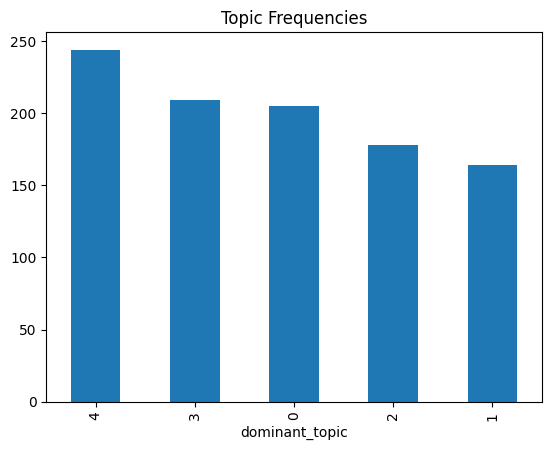

In [21]:
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

dominant_topics = []
for i, doc in enumerate(corpus):
    topic_probs = lda_model.get_document_topics(doc)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

df["dominant_topic"] = dominant_topics

topic_counts = df["dominant_topic"].value_counts()
print("\nTopic Frequency:")
print(topic_counts)

topic_counts.plot(kind='bar', title="Topic Frequencies")

topic_sentiment = df.groupby("dominant_topic")["sentiment"].value_counts(normalize=True) * 100
print("\nSentiment by Topic (%):")
print(topic_sentiment)


### ✍️ Your Response: 🔧
List your topics and names here:
1. Topic #0 – “General Experience & Ratings”
2. Topic #1 – “Friendly Service & Returning Customers”
3. Topic #2 – “Taste & Food Quality”
4. Topic #3 – “Service Problems & Complaints”
5. Topic #4 – “Positive Restaurant Experience”


## 8. Reflect and Recommend

**Business framing:**  
Ultimately, the value of your model comes from how well it can guide business decisions. Use your results to make real-world recommendations.

### In Your Response:
1. What business question did your model help answer?
2. What would you recommend to this restaurant to improve customer satisfaction?
3. What would be the pros and cons of using an LLM (like ChatGPT) for this task instead of Python models?
4. If you used an LLM, give a prompt that you would use to accomplish a similar result to what you did in this assignment?  (remember to set the context, specify the output and explain the objectives)


### ✍️ Your Response: 🔧
1. The model helped answer whether customer “Likes” matched the underlying sentiment of their written reviews, and what key topics customers talked about most frequently.

2. Based on the topic and sentiment analysis, I would recommend focusing on improving service consistency, reducing wait times, and maintaining food quality, since these appeared as recurring themes across topics.

3.
Pros:

– Faster insights without coding

– Ability to summarize large text blocks

– Flexible, conversational, easy to use

– Can generate business recommendations instantly

Cons:

– Less reproducible than Python models

– Harder to validate or benchmark performance

– Can hallucinate or produce inconsistent results

– No direct control over algorithms or parameters

4. “Analyze the following 1,000 restaurant reviews. Identify sentiment (positive, negative, neutral), find the main topics customers talk about, summarize each topic with 2–3 words, and provide business recommendations to improve customer satisfaction. Return the results in a clear, structured format.”

## Submission Instructions
✅ Checklist:
- All code cells run without error
- All markdown responses are complete
- Submit on Canvas as instructed

In [22]:
!jupyter nbconvert --to html "assignment_13_FajardoPatrick.ipynb"

[NbConvertApp] Converting notebook assignment_13_FajardoPatrick.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 369746 bytes to assignment_13_FajardoPatrick.html
